In this notebook, we train a model using more of Cellposes' pre- and post-processing functions

In [1]:
from import_images import getImages
import numpy as np
import torch
from cellpose import resnet_torch
from cellpose import transforms
import cv2
import time
from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
from torchmetrics.classification import BinaryJaccardIndex
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ezomero
from omero_data import connect, extract_channel, progressbar

c:\Users\rz200\Anaconda3\envs\cellpose\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_pre_activations(image,cpnet):
    x = torch.from_numpy(image)
    downsample = cpnet.downsample(x)
    style = cpnet.make_style(downsample[-1])
    upsample = cpnet.upsample(style, downsample, cpnet.mkldnn)
    
    output = cpnet.output(upsample).squeeze(0)
    output = output.cpu().detach().numpy()
    output = np.array(output)

    upsample = upsample.squeeze(0)
    upsample = upsample.cpu().detach().numpy().tolist()
    upsample = np.array(upsample)
    return upsample, output

class ImageDataset(Dataset):
    def __init__(self, image, upsample, cellprob):
        self.image = image
        self.upsample = upsample
        self.cellprob = cellprob

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        upsample = self.upsample[idx]
        cellprob = self.cellprob[idx]
        return img, upsample, cellprob
    
class KD_loss(torch.nn.Module):
    def __init__(self, alpha, beta):
        super(KD_loss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, y_32_pred, y_32_true, y_3_pred, y_3_true):
        #32-channel loss
        #y_32_pred = F.sigmoid(y_32_pred)
        #y_32_true = F.sigmoid(y_32_true)

        #teacher_mean = torch.mean(y_32_true)
        #teacher_std = torch.std(y_32_true)
        #logits_mean = torch.mean(y_32_pred)
        #logits_std = torch.std(y_32_pred)
        #scaled_logits = (y_32_pred - logits_mean) * (teacher_std / logits_std) + teacher_mean

        #y_32_loss = F.mse_loss(scaled_logits, y_32_true)
        #y_32_loss = F.mse_loss(y_32_pred, y_32_true)
        y_32_pred = F.log_softmax(y_32_pred, dim=1)
        y_32_true = F.log_softmax(y_32_true, dim=1)
        y_32_loss = F.kl_div(y_32_pred, y_32_true, log_target=True)
        print(y_32_loss)
        #print(y_32_loss)
        #3-channel loss
        flow_loss = F.mse_loss(y_3_pred[:,:2], y_3_true[:,:2])
        flow_loss /= 2.
        map_loss = F.mse_loss(y_3_pred[:,2] , y_3_true[:,2])
        y_3_loss = flow_loss + map_loss
        return y_32_loss * self.alpha, y_3_loss * self.beta

def trainEpoch(unet, train_loader, test_loader, validation_loader, loss_fn, optimiser, scheduler, epoch_num, device):
    time_start = time.time()
    
    unet.train()

    train_y_32_loss, train_map_loss = 0, 0

    for image, upsample, cp_output in train_loader:

        
        image, upsample, cp_output = image.float(), upsample.float(), cp_output.float() #cast to float32 (important for mps)

        if device is not None:
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)

        #image = image.unsqueeze(1)
        y_16_pred, y_32_pred, map_pred = unet(image)
        y_32_pred = y_32_pred.squeeze(1)
        map_pred = map_pred.squeeze(1)
    
        loss_32, loss_map = loss_fn(y_32_pred,  upsample, map_pred, cp_output) # calculate the loss of that prediction
        train_y_32_loss += loss_32.item()
        train_map_loss += loss_map.item()

         # zero out the accumulated gradients

        #I want to get two losses, one for the 32-channel output and one for the 3-channel output
        #I then want to freeze certain channels before putting the losses backwards
        unet.encoder.requires_grad = True #repetitive but just to be clear
        unet.decoder.requires_grad = True
        unet.head.requires_grad = False
        loss_32.backward(retain_graph=True)

        
        unet.encoder.requires_grad = False
        unet.decoder.requires_grad = False
        unet.head.requires_grad = True
        loss_map.backward(retain_graph=True)

        optimiser.step() # update model parameters
        optimiser.zero_grad()

    if scheduler is not None:
        scheduler.step()

    train_y_32_loss, train_map_loss = train_y_32_loss/len(train_loader), train_map_loss/len(train_loader)


    val_y_32_loss, val_map_loss, val_IoU = 0, 0, 0
    for image, upsample, cp_output in validation_loader:
        
        image, upsample, cp_output = image.float(), upsample.float(), cp_output.float() #cast to float32 (important for mps)

        if device is not None:
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)

        #image = image.unsqueeze(1)
        y_16_pred, y_32_pred, map_pred = unet(image)
        y_32_pred = y_32_pred.squeeze(1)
        map_pred = map_pred.squeeze(1)
    
        loss_32, loss_map = loss_fn(y_32_pred,  upsample, map_pred, cp_output) # calculate the loss of that prediction
        val_y_32_loss += loss_32.item()
        val_map_loss += loss_map.item()

        #IoU score
        jaccard = BinaryJaccardIndex(threshold=0.5).to(device)
        map_pred = F.sigmoid(map_pred)
        cp_output = F.sigmoid(cp_output)
        cp_output = torch.where(cp_output > 0.5, 1.0, 0.0)
        iou = jaccard(map_pred, cp_output)
        if not torch.isnan(iou):
            val_IoU += iou
        else:
            val_IoU += 0
        

    val_y_32_loss, val_map_loss, val_IoU = val_y_32_loss/len(validation_loader), val_map_loss/len(validation_loader), val_IoU.item()/len(validation_loader)
    
    #we might add displaying later on
    
    if epoch_num is None:
        print('Train 32 loss: ', train_y_32_loss,'Train map loss', train_map_loss, 'Val 32 loss: ', val_y_32_loss, 'Val map loss: ', val_map_loss, 'Val IoU: ', val_IoU, 'Time: ', time.time()-time_start)
    else:
        print('Epoch: ', epoch_num, 'Train 32 loss: ', train_y_32_loss,'Train map loss', train_map_loss, 'Val 32 loss: ', val_y_32_loss, 'Val map loss: ', val_map_loss, 'Val IoU: ', val_IoU, 'Time: ', time.time()-time_start)

    return unet    

def get_omero_images_combined(num_images=None, channels=[0,0]):
    conn = connect(user='rz200',password='omeroreset')

    plate = 1237
    if num_images == None:
        image_ids = ezomero.get_image_ids(conn,plate=plate)
    else:
        image_ids = ezomero.get_image_ids(conn,plate=plate)[:num_images]

    print('In plate',plate,'we have',len(image_ids),'images')

   

    data_images = []
    for i in progressbar(range(len(image_ids)), "Computing: ", 40):
        data_images.append(ezomero.get_image(conn, image_ids[i])[1])

    if len(channels) == 2 and channels != [0,0]:
        data_images_one = extract_channel(data_images, channels[0])
        data_images_two = extract_channel(data_images, channels[1])

        combined_images = []
        for i in range(len(data_images_one)):
            combined_images.append(np.array([data_images_one[i] , data_images_two[i]]))
    
        return combined_images
    elif len(channels) == 1:
        data_images_one = extract_channel(data_images, channels[0])
        return data_images_one
    else:
        return data_images

def normalize_un(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def get_cellpose_data(cpnet, combined_images):
    images_tiled = []
    ys = []
    all_upsamples = []

    for i in range(len(combined_images)):
        print(i)
        image_t = combined_images[i]


        if len(image_t.shape) == 2:
            image_t = [image_t,image_t]
            image_t = np.array(image_t)
        
        image_t = normalize_un(image_t)

        IMG, ysub, xsub, Ly, Lx = transforms.make_tiles(image_t, bsize=224, 
                                                        augment=False, tile_overlap=0.1)
        ny, nx, nchan, ly, lx = IMG.shape
        IMG = np.reshape(IMG, (ny*nx, nchan, ly, lx))
        images_tiled.append(IMG)
        batch_size = 1
        niter = int(np.ceil(IMG.shape[0] / batch_size))
        nout = 3 + 32*False
        y = np.zeros((IMG.shape[0], nout, ly, lx))
        styles = []

        upsamples = []

        for k in range(niter):
            irange = np.arange(batch_size*k, min(IMG.shape[0], batch_size*k+batch_size))
            upsample, y0 = get_pre_activations(IMG[irange], cpnet)
            upsamples.append(upsample)
            y[irange] = y0.reshape(len(irange), y0.shape[-3], y0.shape[-2], y0.shape[-1])

        ys.append(y)

        upsamples = np.array(upsamples)
        all_upsamples.append(upsamples)

    images_tiled_np = np.array(images_tiled)
    ys_np = np.array(ys)
    all_upsamples_np = np.array(all_upsamples)

    images_tiled_np = images_tiled_np.reshape(images_tiled_np.shape[0]*images_tiled_np.shape[1], images_tiled_np.shape[2], images_tiled_np.shape[3], images_tiled_np.shape[4])
    ys_np = ys_np.reshape(ys_np.shape[0]*ys_np.shape[1], ys_np.shape[2], ys_np.shape[3], ys_np.shape[4])
    all_upsamples_np = all_upsamples_np.reshape(all_upsamples_np.shape[0]*all_upsamples_np.shape[1], all_upsamples_np.shape[2], all_upsamples_np.shape[3], all_upsamples_np.shape[4])
        
    return images_tiled_np, ys_np, all_upsamples_np


In [3]:
directory = "/Users/rz200/Documents/development/distillCellSegTrack/pipeline/CellPose_models/U2OS_Tub_Hoechst"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

In [19]:
combined_images = get_omero_images_combined(num_images=3, channels=[1, 2])


Connection successful
In plate 1237 we have 3 images
Computing: [########################################] 3/3



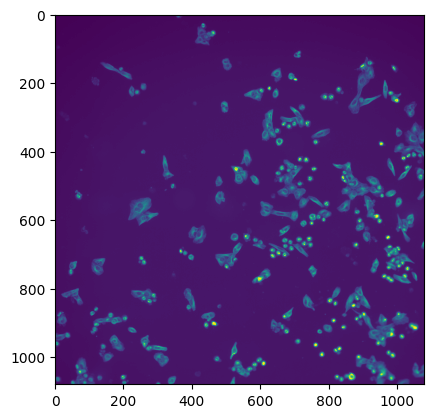

In [20]:
plt.imshow(combined_images[0][0])

In [21]:
print(combined_images[0].shape)

(2, 1080, 1080)


In [22]:
images_tiled, ys, all_upsamples = get_cellpose_data(cpnet, combined_images[:3])

0
1
2


In [23]:
print(np.unique(images_tiled[0]))

[0.0000000e+00 2.4630543e-04 3.0788177e-04 ... 5.2589285e-01 5.3063422e-01
 5.4137933e-01]


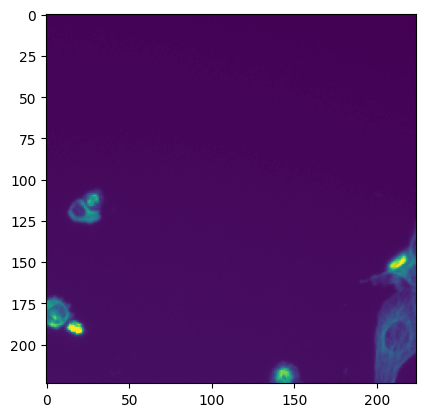

In [24]:
plt.imshow(images_tiled[4][0])

In [284]:
from cellpose import transforms

#normalising the tiles and not normalising the images entirely before tiling means that we bring artefacts into the tiles
images_tiled_normalised = []
for i in range(len(images_tiled)):
    images_tiled_normalised.append(transforms.normalize_img(images_tiled[i]))

KeyboardInterrupt: 

In [8]:
print(images_tiled_normalised[0])

[[[3.9145909e-02 6.3291140e-02 1.0142631e-01 ... 1.2484951e-03
   1.9945041e-03 4.3366668e-03]
  [8.8967972e-02 3.7974682e-02 8.3993658e-02 ... 1.3822624e-03
   4.8754542e-04 3.5401364e-04]
  [7.4733093e-02 8.3544306e-02 9.0332806e-02 ... 1.4714407e-03
   1.2410247e-03 3.8498982e-03]
  ...
  [2.3487544e-01 2.2531645e-01 1.8066561e-01 ... 1.0000000e+00
   1.0000000e+00 9.3756086e-01]
  [3.1672597e-01 1.6202532e-01 1.4421552e-01 ... 1.0034333e+00
   9.1707295e-01 8.4445524e-01]
  [4.1992882e-01 3.1898734e-01 1.5847860e-01 ... 1.0066884e+00
   9.4153887e-01 9.1198337e-01]]

 [[3.9145909e-02 6.3291140e-02 1.0142631e-01 ... 1.2484951e-03
   1.9945041e-03 4.3366668e-03]
  [8.8967972e-02 3.7974682e-02 8.3993658e-02 ... 1.3822624e-03
   4.8754542e-04 3.5401364e-04]
  [7.4733093e-02 8.3544306e-02 9.0332806e-02 ... 1.4714407e-03
   1.2410247e-03 3.8498982e-03]
  ...
  [2.3487544e-01 2.2531645e-01 1.8066561e-01 ... 1.0000000e+00
   1.0000000e+00 9.3756086e-01]
  [3.1672597e-01 1.6202532e-01 1.442

In [25]:
print(all_upsamples.shape)

(108, 32, 224, 224)


In [286]:
print(images_tiled.shape)

(108, 2, 224, 224)


In [26]:
train_images, test_images, train_upsamples, test_upsamples, train_cellprob, test_cellprob = train_test_split(images_tiled[:100], all_upsamples[:100], ys[:100], test_size=0.1, random_state=42)
train_images, val_images, train_upsamples, val_upsamples, train_cellprob, val_cellprob = train_test_split(train_images, train_upsamples, train_cellprob, test_size=0.1, random_state=42)

train_dataset = ImageDataset(train_images, train_upsamples, train_cellprob)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

validation_dataset = ImageDataset(val_images, val_upsamples, val_cellprob)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

test_dataset = ImageDataset(test_images, test_upsamples, test_cellprob)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

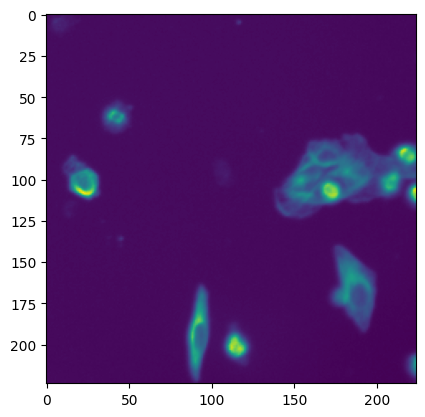

In [27]:
plt.imshow(train_images[4][0])

In [291]:
print(np.unique(train_upsamples[67]))

[-80.89780426 -79.46791077 -77.42755127 ...  28.41119194  28.50793076
  28.61375046]


In [28]:
unet = UNet(encChannels=(2,32,64,128,256),decChannels=(256,128,64,32),nbClasses=3) #it's not a problem to train it with 2 channels as anyway it is just the same channel repeated twice for the nuclei model but that may make more parameters to train so we may want to chang ethat
unet = unet.to('cuda:0')

In [29]:
loss_fn = KD_loss(alpha=1, beta=1)
optimiser = torch.optim.SGD(unet.parameters(), lr=0.0001, momentum=0.1)

#I DEACTIVATED THE STEP LOSS SCHEDULER FOR NOW
#I think a decaying scheduler is best, not a cyclic one
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=0.1)
scheduler = None

for epoch in range(500):
    #we really need to change to 'best IoU' saves the model
    #print(scheduler.get_last_lr())
    unet = trainEpoch(unet, train_loader, test_loader, validation_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, device='cuda:0')
    torch.save(unet.state_dict(), "unet_U2Os_Tub_Hoechst_test_2")

c:\Users\rz200\Anaconda3\envs\cellpose\lib\site-packages\torch\nn\functional.py:2886: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


tensor(0.0307, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0244, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0264, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0364, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0236, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0295, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0222, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0333, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0260, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0314, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0189, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0295, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0152, device='cuda:0', grad_fn=<KlDivBackward0>)
Epoch:  0 Train 32 loss:  0.027525224976918915 Train map loss 20.585146730596367 Val 32 loss:  0.022319582290947437 Val map loss:  16.348546981811523 Val IoU:  0.2181967794895172 Time:  14.425768613815308


c:\Users\rz200\Anaconda3\envs\cellpose\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.0334, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0265, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0303, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0349, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0222, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0296, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0227, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0254, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0262, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0317, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0276, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0277, device='cuda:0', grad_fn=<KlDivBackward0>)
tensor(0.0295, device='cuda:0', grad_fn=<KlDivBackward0>)
Epoch:  1 Train 32 loss:  0.02821681546893987 Train map loss 17.968779043717817 Val 32 loss:  0.028603680431842804 Val map loss:  18.974202156066895 Val IoU:  0.3154332935810089 Time:  7.842090606689453
tensor(0.0351, device='cuda:0', grad_fn=<Kl

KeyboardInterrupt: 

In [30]:
import gc
torch.cuda.empty_cache()
gc.collect()

3708

In [31]:
test_image = test_images[2]
print(test_image)

[[[0.07271663 0.07481097 0.07611993 ... 0.0739332  0.07194666 0.06988312]
  [0.07692071 0.07616613 0.07314782 ... 0.07103808 0.07285523 0.07071469]
  [0.0739486  0.07685911 0.07354821 ... 0.06886674 0.07108428 0.06977532]
  ...
  [0.06818917 0.07005251 0.07106888 ... 0.06446248 0.06475507 0.06185996]
  [0.06929793 0.06832776 0.06791198 ... 0.06327672 0.06457028 0.06443168]
  [0.0703451  0.07290143 0.07113048 ... 0.06640282 0.06654142 0.06592543]]

 [[0.01746308 0.01757088 0.01955742 ... 0.01767867 0.0169241  0.01883364]
  [0.01613872 0.0168009  0.01960362 ... 0.01647751 0.01729368 0.0168471 ]
  [0.01767867 0.01650831 0.01786347 ... 0.01706269 0.0166315  0.01704729]
  ...
  [0.01727829 0.0166469  0.01809446 ... 0.01601552 0.01655451 0.01441397]
  [0.01915703 0.01860265 0.01701649 ... 0.01583073 0.01743228 0.01576913]
  [0.01709349 0.01718589 0.01583073 ... 0.01638511 0.01615412 0.01555354]]]


In [32]:
pred = unet(torch.from_numpy(test_image).unsqueeze(0).to('cuda:0'))

In [33]:
print(np.unique(pred[2].cpu().detach().numpy())>0.5)

[False False False ...  True  True  True]


In [34]:
print(test_images[0][0])

[[0.06265198 0.0615593  0.06406784 ... 0.04560005 0.04469205 0.04493829]
 [0.06482194 0.06226723 0.06179015 ... 0.04570778 0.04373788 0.04706208]
 [0.06134384 0.06263658 0.06440642 ... 0.04656961 0.04778541 0.04472283]
 ...
 [0.07094709 0.07240912 0.07311705 ... 0.06091293 0.06028194 0.05874296]
 [0.07304011 0.07125489 0.07050078 ... 0.06086675 0.05922004 0.0618517 ]
 [0.0697159  0.07351719 0.07420973 ... 0.06040506 0.05977408 0.06168241]]


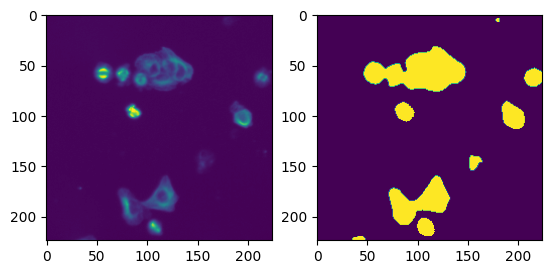

In [35]:
plt.subplot(1,2,1)
plt.imshow(test_images[2][0])
plt.subplot(1,2,2)
plt.imshow(pred[2].cpu().detach().numpy()[0][2]>0.5)
plt.show()

In [192]:
#save the model
torch.save(unet.state_dict(), "unet_nuclei_hoechst_test_12")

In [36]:
%load_ext autoreload
%autoreload 2

from unet_instance_2_chans import UNetModel as UNet_2chans

model = UNet_2chans(encChannels=(2,32,64,128,256),decChannels=(256,128,64,32),nbClasses=3)
model.load_weights("unet_U2Os_Tub_Hoechst_test_2")
model.set_device('cuda')

(3, 1080, 1080)
(1080, 1080, 3)
(3, 1080, 2)
(1080, 1080, 2)
reasse (1080, 1080)
ggggg


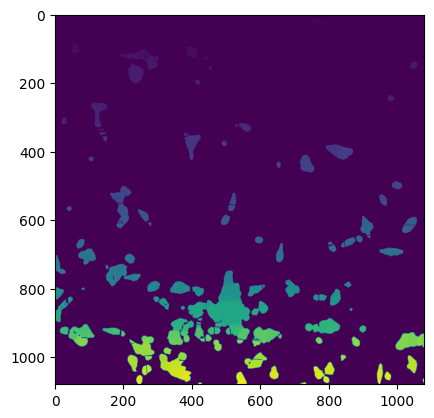

In [37]:
predictions = model.predict(normalize_un(combined_images[1]),normalize=False)
plt.imshow(predictions[0][4])

527


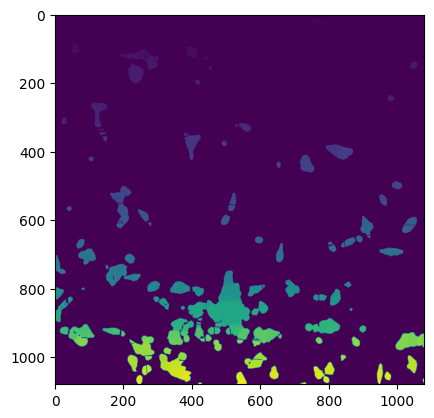

404


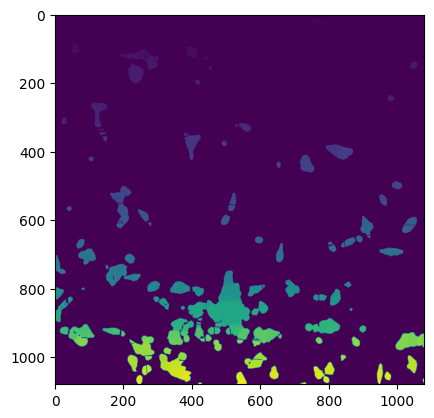

In [38]:
#instance_segmentation, outputs, dP, reassembled_image, instance_segmentation_2
print(np.unique(predictions[0][4])[-1])

plt.imshow(predictions[0][4]);plt.show()

#for each unique pixel value in predictions[0][4], if the number of pixels with that value is less than 20, set them to 0
instance_seg = predictions[0][4].copy()
unique_values = np.unique(instance_seg[1:])
counts = np.bincount(instance_seg.flatten())
indices_to_zero = unique_values[counts[unique_values] < 40]
instance_seg[np.isin(instance_seg, indices_to_zero)] = 0

print(len(np.unique(instance_seg)))
plt.imshow(instance_seg)

In [39]:
#trying Cellpose to compare
from cellpose import models

segmentation_model = models.CellposeModel(gpu=True, model_type="C:/Users/rz200/Documents/development/distillCellSegTrack/pipeline/CellPose_models/U2OS_Tub_Hoechst")

In [44]:
n_channels = [[1, 2]]
n_mask_array, n_flows, n_styles = segmentation_model.eval(combined_images[1], channels=n_channels)

130


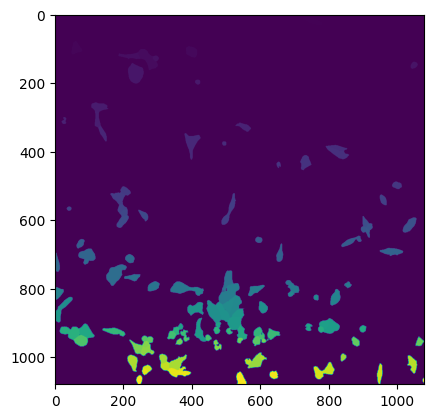

In [45]:
plt.imshow(n_mask_array)
print(len(np.unique(n_mask_array)))

In [254]:
print(n_mask_array.shape, instance_seg.shape)

n_mask_array_binary= np.where(n_mask_array>0, 1, 0)
instance_seg_binary = np.where(instance_seg>0, 1, 0)

intersection = np.logical_and(n_mask_array_binary, instance_seg_binary).sum()
union = np.logical_or(n_mask_array_binary, instance_seg_binary).sum()
iou = intersection / (union)
print(iou)

(1080, 1080) (1080, 1080)
0.6221277291683702


NameError: name 'n_mask_array' is not defined

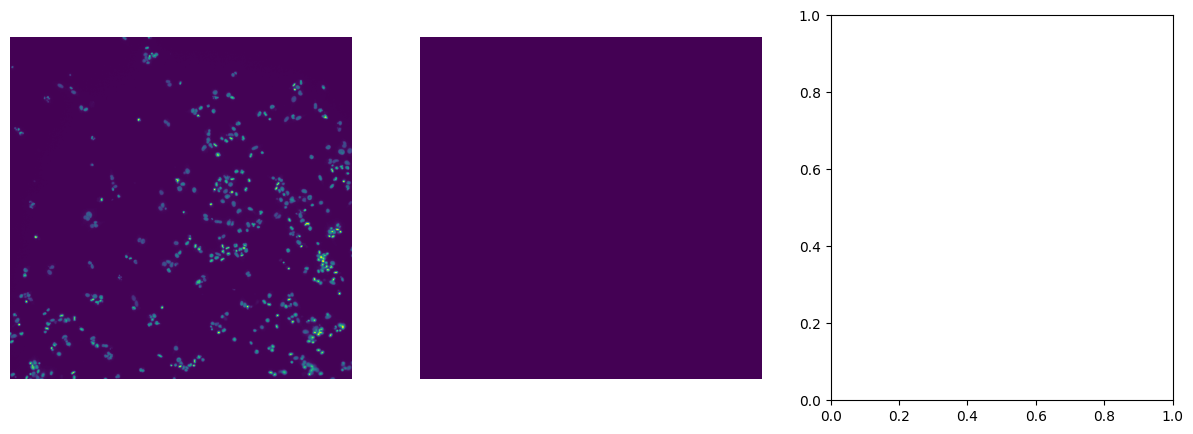

In [213]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(combined_images[0])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(predictions[0][1])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(n_mask_array)
plt.axis('off')
plt.show()

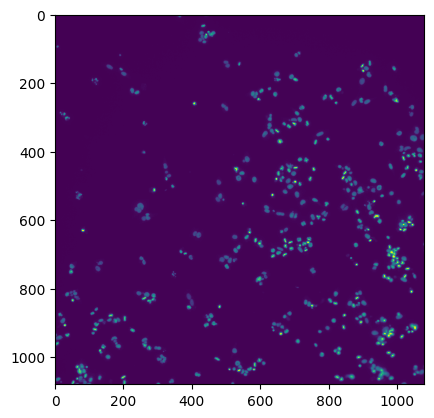

In [258]:
plt.imshow(combined_images[0])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

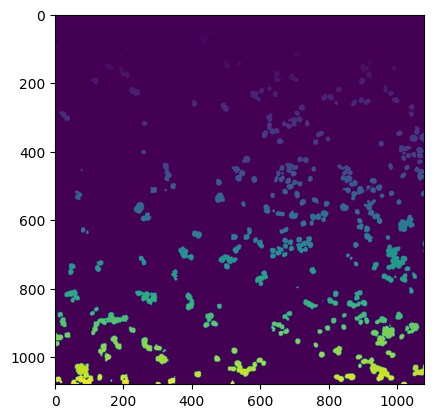

In [251]:
plt.imshow(predictions[0][4])
print(np.unique(predictions[0][4]))

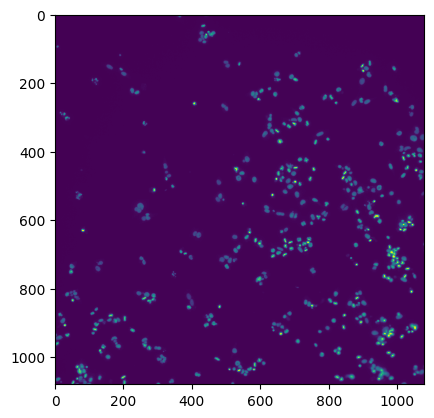

In [239]:
plt.imshow(combined_images[0])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84]


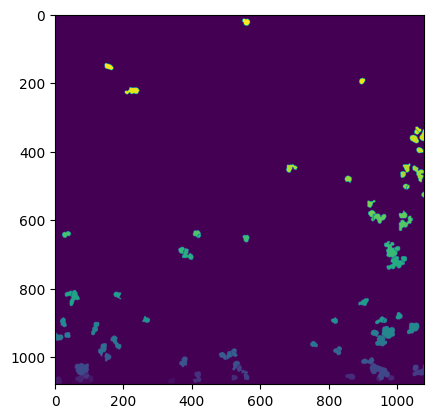

In [182]:
plt.imshow(predictions[0][0])
print(np.unique(predictions[0][0]))

In [53]:
print(predictions[0][3])

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84]


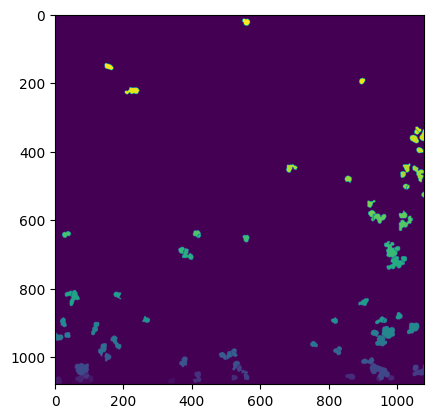

In [158]:
plt.imshow(predictions[0][0])
print(np.unique(predictions[0][0]))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135]


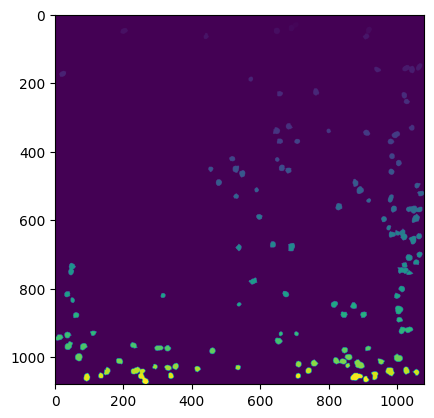

In [63]:
plt.imshow(predictions[0][1][0])
print(np.unique(predictions[0][1][0]))

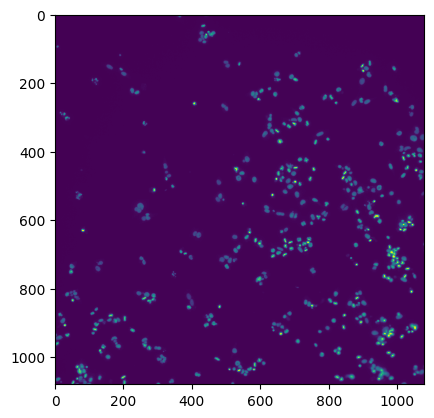

In [48]:
plt.imshow(combined_images[0])

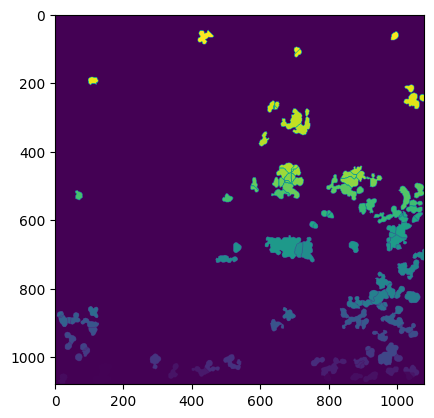

In [46]:
plt.imshow(predictions[0][0])

In [47]:
print(np.unique(predictions[0][0]))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131]


In [385]:
from cellpose import dynamics

test_image = combined_images[1]
test_image = np.array([test_image,test_image])

#image = transforms.normalize_img(test_image)

tiles, ysub, xsub, Ly, Lx = transforms.make_tiles(test_image, bsize=224, 
                                        augment=True, tile_overlap=0.1)

# Predicting
ny, nx, nchan, ly, lx = tiles.shape
tiles = np.reshape(tiles, (ny*nx, nchan, ly, lx))
batch_size = 1
niter = int(np.ceil(tiles.shape[0] / batch_size))
nout = 3 + 32*False
y_unet = np.zeros((tiles.shape[0], nout, ly, lx))


for k in range(niter):
    irange = np.arange(batch_size*k, min(tiles.shape[0], batch_size*k+batch_size))
    #print('IMG irange',tiles[irange].shape)
    _, _, y0_unet = unet(torch.from_numpy(tiles[irange]).to('cuda:0'))
    y0_unet = y0_unet.cpu().detach().numpy()
    y_unet[irange] = y0_unet.reshape(len(irange), y0_unet.shape[-3], y0_unet.shape[-2], y0_unet.shape[-1])

yf = transforms.average_tiles(y_unet, ysub, xsub, Ly, Lx)

In [386]:
yf = yf[:,:test_image.shape[1],:test_image.shape[2]]

shape = test_image.shape
dP = np.zeros((2, 1, int(shape[1]*1), int(shape[2]*1)), np.float32)
cellprob = np.zeros((1, int(shape[1]*1), int(shape[2]*1)), np.float32)

yf_t = yf.transpose(1,2,0)
print(yf.shape)
cellprob[0] = yf_t[:,:,2]
cellprob = cellprob[0]
dP[:, 0] = yf[:2,:,:]

# Post processing
reassembled_image = 1 / (1 + np.exp(-cellprob))
reassembled_image = reassembled_image > 0.5
instance_segmentation = mod._binary_to_instance(reassembled_image)

outputs = dynamics.compute_masks(yf_t[:,:,:2].transpose((2,0,1)), yf_t[:,:,2], niter=156, cellprob_threshold=0,
                                                    flow_threshold=0.4, interp=True, resize=None, 
                                                    use_gpu=True, device="cuda:0")

(3, 1080, 1080)


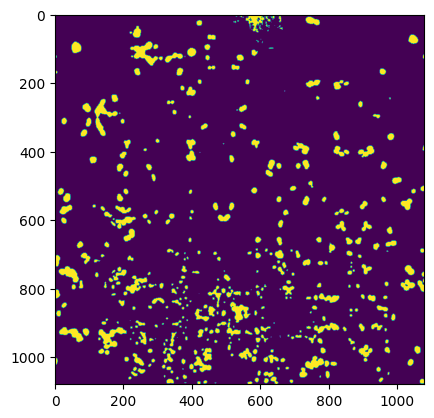

In [387]:

cp_mask = cellprob > 0.0 
plt.imshow(cp_mask) 

In [389]:
print(dP.shape)

(2, 1, 1080, 1080)


In [390]:
dP = dP.squeeze(1)
dP = 1/(1+np.exp(-dP))

In [391]:
from cellpose.dynamics import steps2D, get_masks

shape = np.array(dP.shape[1:]).astype(np.int32)
p = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
p = np.array(p).astype(np.float32)
inds = np.array(np.nonzero(np.abs(dP[0])>1e-3)).astype(np.int32).T
p = steps2D(p, dP.astype(np.float32), inds, niter)
print(inds.shape)

(1166318, 2)


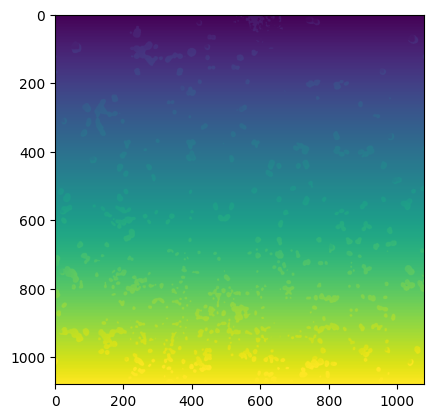

In [394]:
plt.imshow(p[0])

In [395]:
from cellpose import utils

mask = get_masks(p, iscell=cp_mask)
mask = utils.fill_holes_and_remove_small_masks(mask, min_size=15)

In [396]:
print(np.unique(mask))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

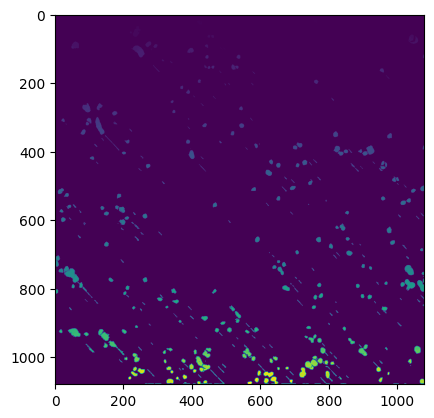

In [397]:
plt.imshow(mask)

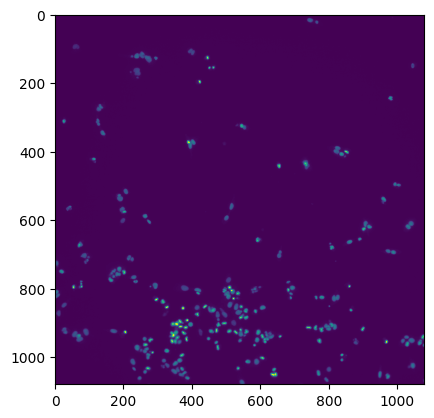

In [398]:
plt.imshow(combined_images[1])

In [ ]:
#need to clean mask
#need to show real image to compare

In [226]:
(np.unique(instance_segmentation))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166])

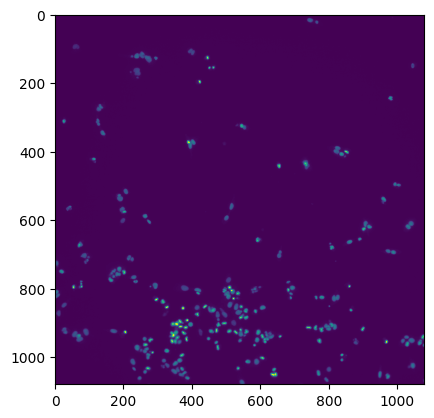

In [200]:
plt.imshow(combined_images[1])

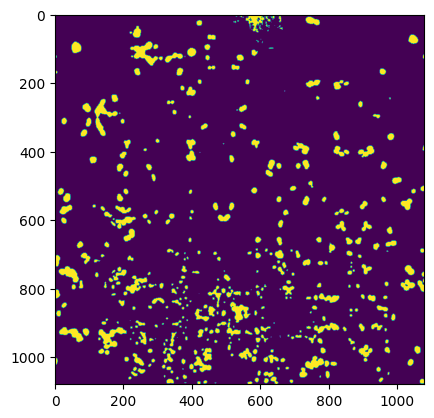

In [227]:
plt.imshow(cellprob>0)

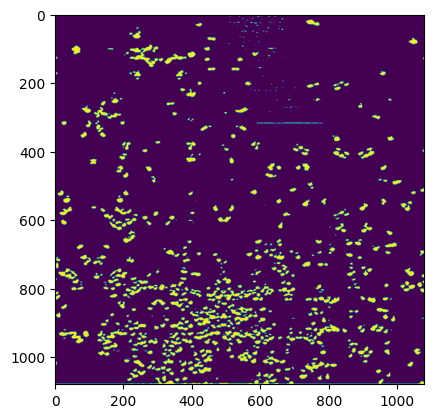

In [215]:
from unet_instance_2_chans import UNetModel as UNet_2chans

mod = UNet_2chans(encChannels=(2,32,64,128,256),decChannels=(256,128,64,32),nbClasses=3)

reassembled_image = 1 / (1 + np.exp(-(dP[0][0])))
plt.imshow(reassembled_image < 0.5)
reassembled_image = reassembled_image < 0.5
instance_segmentation = mod._binary_to_instance(reassembled_image)



[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

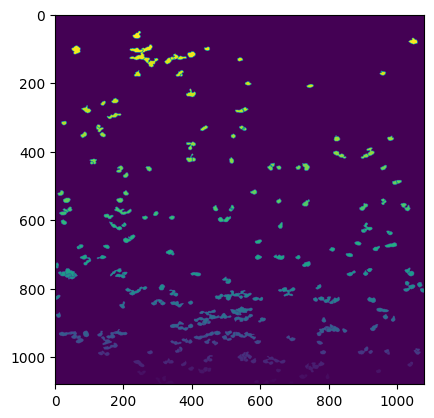

In [217]:
plt.imshow(instance_segmentation)
print(np.unique(instance_segmentation))

[-17.11002  -16.979692 -16.297554 ...  13.175228  13.465097  13.646183]


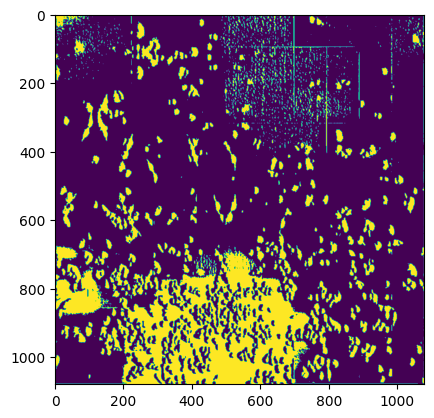

In [229]:
plt.imshow(dP[1][0]<0)
print(np.unique(dP[1][0]))

[-17.11002  -16.979692 -16.297554 ...  13.175228  13.465097  13.646183]


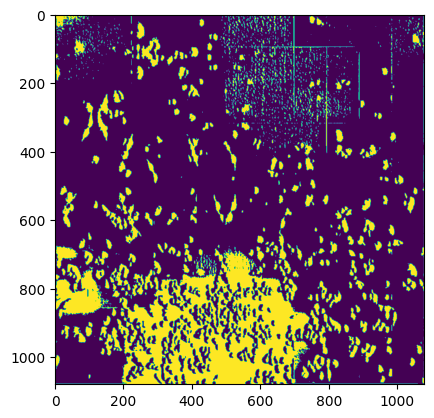

In [197]:
plt.imshow(dP[1][0]<0)
print(np.unique(dP[1][0]))

In [168]:
print(len(predictions[0]))

3


In [ ]:
instance_segmentation, outputs, dP = predictions[0]

In [ ]:
print(dP.shape)

(2, 1, 1080, 1080)


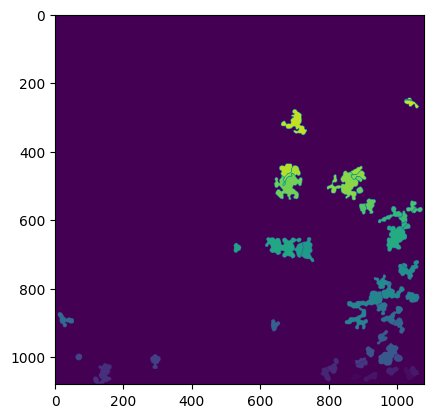

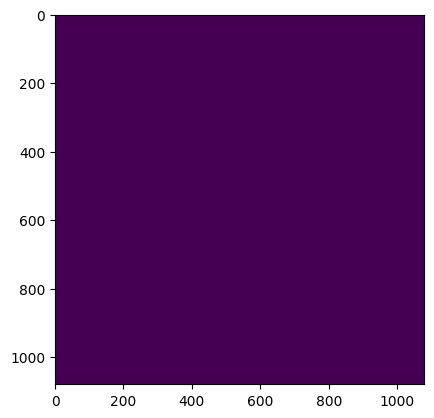

In [ ]:
plt.imshow(instance_segmentation); plt.show()
plt.imshow(dP[0][0]); plt.show()

In [ ]:
print(output.shape)

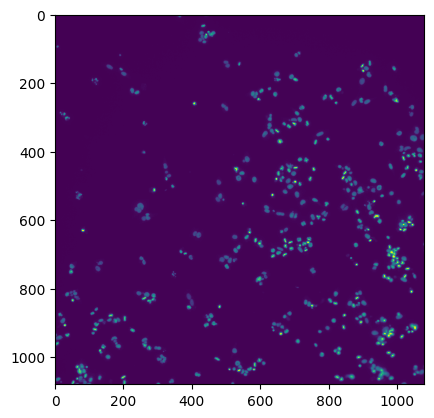

In [109]:
plt.imshow(combined_images[0])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]


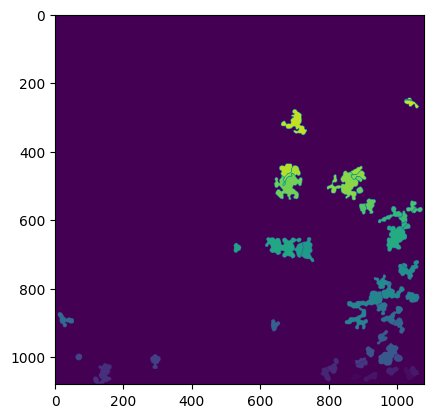

In [110]:
print(np.unique(prediction))
plt.imshow(prediction[0])